In [97]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool 
import seaborn as sns

In [80]:
df = pd.read_json("/shared/4/projects/podcasts/processed/floydMonthData.jsonl", orient="records", lines=True)

In [81]:
def getGrams(inStr, gramLen=4): 
    wordList = inStr.split()
    numWords = len(wordList)
    gramList = []
    gramDict = {}
    gramCount = 0
    maxCount = 0
    maxGram = ""
    for i, word in enumerate(wordList): 
        
        j = i + gramLen

        #if we have enough words left, append the gram
        if j < numWords: 
            
            gram = " ".join(list(wordList[i:j])).lower()
            
            
            if gram not in gramDict: 
                gramDict[gram] = 1
            else: 
                gramDict[gram] += 1

            #if this is the new most common gram, update
            currGramCount = gramDict[gram]
            if currGramCount > maxCount: 
                maxCount = currGramCount
                maxGram = gram
            
            gramCount += 1

    return [gramCount, maxCount, maxGram]
    


In [82]:
def getGramsWrapper(tup): 
    i, indices=tup
    currDf = df.iloc[indices]
    gramOutput = currDf["transcript"].apply(getGrams)
    return gramOutput

In [83]:
N_SPLITS=15
indexList = np.array_split(np.array(list(range(0, len(df)))), N_SPLITS)
zippedIndices = list(zip(list(range(0, N_SPLITS)), indexList))

In [84]:
with Pool(N_SPLITS) as p: 
    outFrames = p.map(getGramsWrapper, zippedIndices)

In [85]:
catOut= np.concatenate(outFrames)
gramDf = pd.DataFrame.from_records(catOut) 

In [86]:
gramDf.columns = ["totalGramCount", "topGramCount", "topGram"]

In [87]:
df = pd.concat([df, gramDf], axis=1)

In [88]:
df = df[df["topGramCount"] > 0]

In [89]:
df["gramFrac"] = df["topGramCount"] / df["totalGramCount"]

In [91]:
#check NER errors
df[["transStarts", "descStarts"]]

,transStarts,descStarts
0,"[4, 30, 125, 362, 417, 451, 485, 520, 639, 112...","[14, 43]"
1,"[4, 30, 125, 362, 406, 469, 497, 517, 532, 653...","[14, 43]"
2,"[4, 30, 125, 362, 425, 459, 568, 656, 668, 909...","[14, 43]"
3,"[1, 265, 282, 312, 345, 399, 410, 968, 1142, 1...",None
4,"[12, 44, 122, 185, 231, 267, 352, 619, 694, 82...","[11, 43, 188, 294, 341]"
...,...,...
591502,"[467, 882, 971, 2360, 3462, 3489, 3596, 3659, ...","[130, 304]"
591503,"[195, 497, 1523, 1563, 1604, 1622, 1660, 1726,...","[130, 304]"
591504,"[0, 51, 274, 341, 466, 592, 621, 647, 801, 838...","[130, 304]"
591505,"[59, 75, 86, 421, 735, 1468, 2408, 2726, 3855,...","[130, 304]"


<Axes: xlabel='gramFrac', ylabel='Proportion'>

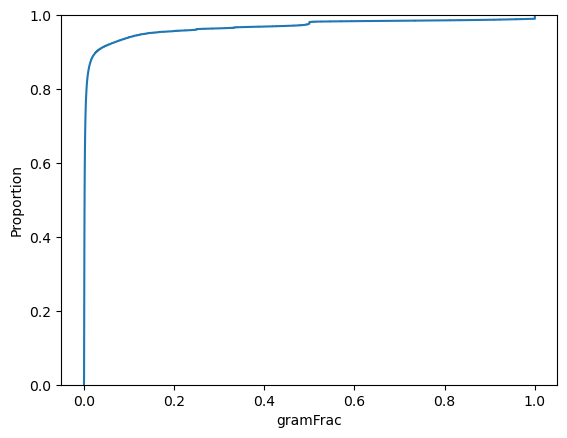

In [98]:
sns.ecdfplot(df, x="gramFrac")

In [96]:
np.mean(df["gramFrac"] > .05)

0.08216720732251113

In [99]:
#seems like 5% is a decent cutoff? 
cleanDf = df[df["gramFrac"] < .05]

In [64]:
test = cleanDf.sample(3000)

In [101]:
cleanDf.shape

(539125, 76)

In [100]:
df.shape

(587558, 76)

In [103]:
cleanDf.to_json("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthDataClean.jsonl", orient="records", lines=True)